# IBCF: 아이템 기반 협업 필터링

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

#### 데이터 읽기

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


#### 데이터 살펴보기

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# 제목으로 영화 찾기
movies[movies.title.str.contains("Inter", case = False)]

,movieId,title,genres
85,96,In the Bleak Midwinter (1995),Comedy|Drama
217,253,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
566,691,Mrs. Winterbourne (1996),Comedy|Romance
1154,1517,Austin Powers: International Man of Mystery (1...,Action|Adventure|Comedy
2402,3186,"Girl, Interrupted (1999)",Drama
2851,3813,Interiors (1978),Drama
3270,4427,"Lion in Winter, The (1968)",Drama
4378,6415,Intervista (1987),Comedy|Drama
4631,6902,Interstate 60 (2002),Adventure|Comedy|Drama|Fantasy|Mystery|Sci-Fi|...
4674,6982,Forbidden Games (Jeux interdits) (1952),Drama|War


In [5]:
# 영화 장르 리스트
gr = []
movies.genres.str.split('|').apply(lambda x: [gr.append(i) for i in x])
list(np.unique(gr))

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# 사용자 수와 사용자 당 평점 횟수
ratings.userId.nunique(), ratings.shape[0] / ratings.userId.nunique()

(610, 165.30491803278687)

In [8]:
# 평점행렬의 일부만 살펴보면 평점 데이터가 일부 위치에만 존재하는 sparse 행렬임을 알 수 있음
ratings.pivot_table('rating', index='userId', columns='movieId').iloc[212:222, 808:817].fillna("")

movieId,1057,1059,1060,1061,1064,1066,1068,1073,1077
userId,,,,,,,,,
213,,,,,,,,,
214,,4.0,,,,,,3.0,
215,,,,3.5,,,,,
216,,,,,,,,,3.0
217,,,,3.0,,,,3.0,2.0
218,,,,,,,,,
219,,,,,,,,2.5,
220,,,,,,,,,
221,,,,,,,,,4.0


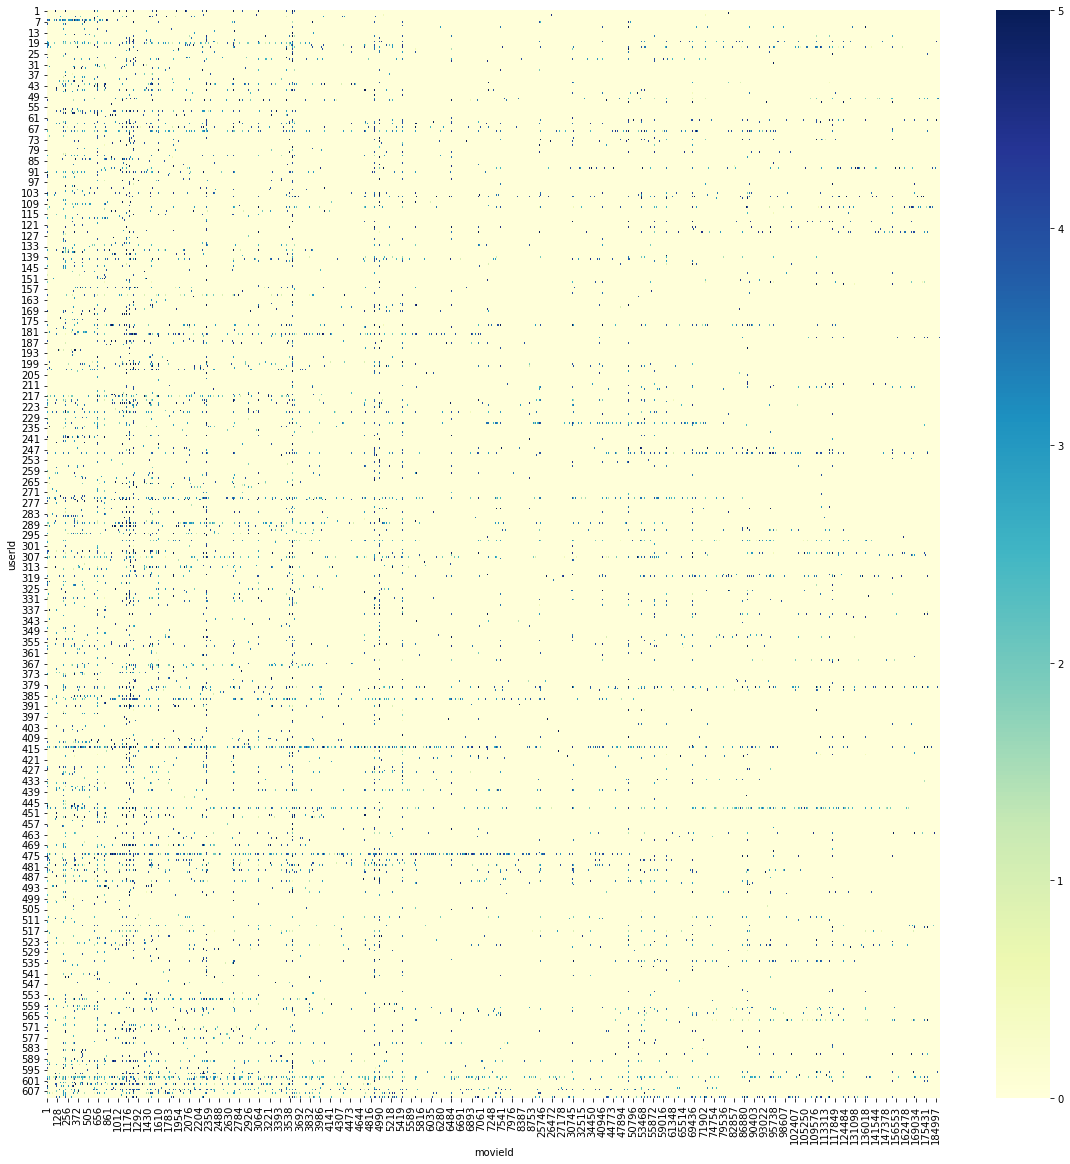

In [9]:
plt.figure(figsize=(20,20))
df = ratings.pivot_table('rating', index='userId', columns='movieId', fill_value=0)
sns.heatmap(df, cmap='YlGnBu')
plt.show()

In [10]:
# Density level (%)
density = ratings.shape[0] / (ratings.userId.nunique() * ratings.movieId.nunique())
f'{round(density*100,2)}%'

'1.7%'

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


<AxesSubplot:>

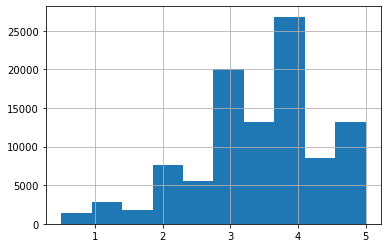

In [11]:
# 평점 분포
print(ratings.describe().rating)
ratings.rating.hist()

In [12]:
#!pip install pandas-profiling
#import pandas_profiling as pp
#pp.ProfileReport(ratings)

## 추천 프로세스
<img align='left' src='http://drive.google.com/uc?export=view&id=10QS0xBx21NahiKdlstDoh0gkQRyrC2vR'>

#### 입력데이터 구성: Ratings Matrix 만들기

In [13]:
# title 컬럼을 얻기 이해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# 행은 userID, 열은 title로 pivoting 수행. rating이 없는 값(NaN)은 모두 0으로 변환
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title', fill_value=0)

print(ratings_matrix.shape)
ratings_matrix.head()

(610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
2,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
5,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


#### 유사집단 탐색: 영화 간 유사도 산출

In [14]:
# 추천 알고리즘 간에 실행시간을 비교하기 위한 코드 
import time
startTime = time.time()

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# cosine_similarity()는 행을 기준으로 유사도를 계산하기 때문에 ratings_matrix를 transpose한 후 적용
item_sim = cosine_similarity(ratings_matrix.T, ratings_matrix.T)

# cosine_similarity()로 반환된 numpy 행렬에 영화명을 매핑하기 위해 DataFrame으로 변환
item_sim = pd.DataFrame(item_sim, ratings_matrix.columns, ratings_matrix.columns)

print(item_sim.shape)
item_sim.head()

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Til There Was You (1997),0.0,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [16]:
# 2010년에 개봉된 "인셉션"과 유사도가 높은 상위 5개 영화 리스트
item_sim["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

#### 추천 상품 결정:  개인화된 영화 추천

$$
\Large \hat{R}_{u,j} = \frac{\sum_{i = 1}^{K}{S_{i,j}*R_{u,i}}} {\sum_{i = 1}^{K}{\left|S_{i,j}\right|}} 
$$

영화 평점 예측

In [17]:
# 유사도가 가장 높은 이웃의 수 설정
K = 20

In [18]:
# 위의 평점예측 수식을 아래와 같이 구현함
R, S = ratings_matrix.values, item_sim.values
# 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
ratings_pred = np.zeros(R.shape)

# 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행. 
for i in range(R.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 K개 데이터 행렬의 index 반환
    top_k = np.argsort(S[:, i])[::-1][1:K+1]
    # 개인화된 예측 평점을 계산
    for u in range(R.shape[0]):
        ratings_pred[u, i] = S[i, :][top_k].dot(R[u, :][top_k].T) 
        ratings_pred[u, i] /= np.sum(np.abs(S[i, :][top_k]))
        
ratings_pred = pd.DataFrame(ratings_pred, ratings_matrix.index, ratings_matrix.columns)
ratings_pred

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.237854,0.000000,0.000000,1.343209,0.295905
2,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.237854,0.000000,0.000000,0.207538,0.000000
5,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000,0.157715,0.0,0.540565,0.176643,0.0,0.138338,0.0,0.117417,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.536920,0.281261,0.000000,0.740281,0.197292
607,0.000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.210006,0.000000,0.000000,0.000000,0.000000
608,0.000,0.000000,0.0,0.169467,0.000000,0.0,0.259268,0.0,0.211351,0.0,...,0.0,0.135076,0.000000,0.114401,0.0,1.149726,3.009715,0.181837,0.748254,0.000000


In [19]:
# 추천 알고리즘 간에 실행시간을 비교하기 위한 코드 
endTime = time.time() - startTime

Top-N 영화 추천

In [20]:
# 추천 영화의 수 설정
N = 10
uid = 9

In [21]:
# id로 지정된 사용자의 모든 영화정보 추출하여 Series로 반환함
# 반환된 user_rating은 영화명(title)을 index로 가지는 Series 객체임 
user_rating = ratings_matrix.loc[uid,:]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list로 만듬
already_seen = user_rating[user_rating > 0].index.tolist()
   
# list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함
unseen_list = [movie for movie in ratings_matrix.columns.tolist() if movie not in already_seen]
    
# unseen_list에서 가장 평점이 높은 N개의 영화를 추천함 
recomm_items = ratings_pred.loc[uid, unseen_list].sort_values(ascending=False)[:N]
list(recomm_items.index)

['Gladiator (2000)',
 'Shrek (2001)',
 'Spider-Man (2002)',
 'Last Samurai, The (2003)',
 'Indiana Jones and the Temple of Doom (1984)',
 'Matrix Reloaded, The (2003)',
 "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
 'Matrix, The (1999)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
 'Monsters, Inc. (2001)']

추천성능 평가

In [22]:
# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 RMSE를 구함
actual, pred = ratings_matrix.values, ratings_pred.values     
pred = pred[actual.nonzero()].flatten()
actual = actual[actual.nonzero()].flatten()
rmse = np.sqrt(mean_squared_error(pred, actual))
print('RMSE of IBCF@K=20: ', rmse)
print(f'Speed of IBCF@K=20: {endTime} sec.')

RMSE of IBCF@K=20:  2.132971466411431
Speed of IBCF@K=20: 102.89880275726318 sec.


# End